In [1]:
import pandas as pd
import numpy as np
import pickle
import yaml
import boto3

## 1. Load the clean data from the Step2- S3_AWS_EDA_EDA_cleaning_data project and stored in the S3 bucket.

Use a function load_data_s3 that receives as parameters the S3 bucket and the path where the file with the stored clean inspection data is located. 

To know which file to download, the list_objects_v2 function of boto3 is used and the name of the stored pkl is identified.

In [2]:
with open('credentials.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

bucket = 'aplicaciones-cd-1-' + config['iexe']['matricula']

def cargar_datos_s3(bucket):

    session = boto3.Session(
        aws_access_key_id = config['s3']['aws_access_key_id'],
        aws_secret_access_key = config['s3']['aws_secret_access_key'],
        aws_session_token = config['s3']['aws_session_token']
    )    
    s3 = session.client('s3')
    key = s3.list_objects_v2(Bucket=bucket, Prefix="ingesta/inicial/")['Contents'][0]['Key']
    print(key)
    s3 = session.resource('s3')
    obj = s3.Object(bucket, key).get()['Body'].read()
    return obj    


In [3]:
session = boto3.Session(
        aws_access_key_id = config['s3']['aws_access_key_id'],
        aws_secret_access_key = config['s3']['aws_secret_access_key'],
        aws_session_token = config['s3']['aws_session_token']
    )    
s3 = session.client('s3')
key = s3.list_objects_v2(Bucket=bucket, Prefix="ingesta/inicial/")['Contents'][0]['Key']
print(key)

ingesta/inicial/datos-limpios-2023-07-09.pkl


In [4]:
def transformar_ingesta(obj):
    df_load = pickle.loads(obj)
    return df_load

## 2. What are the 5 types of establishments with the most inspections in the entire dataset?

Generate a bar chart

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
bucket = 'aplicaciones-cd-1-' + config['iexe']['matricula']
obj = cargar_datos_s3(bucket)
df = transformar_ingesta(obj)
df = pd.DataFrame(df)

ingesta/inicial/datos-limpios-2023-07-09.pkl


In [7]:
df.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,latitude,longitude,location,violations
0,67732,WOLCOTT'S,TROQUET,1992039,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04,License Re-Inspection,Pass,41.961606,-87.675967,"{'latitude': '41.961605669949854', 'longitude'...",NaN
1,67757,DUNKIN DONUTS/BASKIN-ROBBINS,DUNKIN DONUTS/BASKIN-ROBBINS,1380279,Restaurant,Risk 2 (Medium),100 W RANDOLPH ST,CHICAGO,IL,60601,2010-01-04,Tag Removal,Pass,41.884586,-87.631010,"{'latitude': '41.88458626715456', 'longitude':...",NaN
2,52234,Cafe 608,Cafe 608,2013328,Restaurant,Risk 1 (High),608 W BARRY AVE,CHICAGO,IL,60657,2010-01-04,License Re-Inspection,Pass,41.938007,-87.644755,"{'latitude': '41.938006880423615', 'longitude'...",NaN
3,70269,mr.daniel's,mr.daniel's,1899292,Restaurant,Risk 1 (High),5645 W BELMONT AVE,CHICAGO,IL,60634,2010-01-04,License Re-Inspection,Pass,41.938443,-87.768318,"{'latitude': '41.93844282365204', 'longitude':...",NaN
5,104236,TEMPO CAFE,TEMPO CAFE,80916,Restaurant,Risk 1 (High),6 E CHESTNUT ST,CHICAGO,IL,60611,2010-01-04,Canvass,Fail,41.898431,-87.628009,"{'latitude': '41.89843137207629', 'longitude':...",18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...


In [8]:
df.shape

(255398, 17)

In [9]:
df['facility_type'].value_counts().sort_values(ascending = False).head(5)

Restaurant                      176831
Grocery Store                    32142
School                           15771
Children's Services Facility      5200
Bakery                            3709
Name: facility_type, dtype: int64

In [10]:
inspecciones_establecimientos = pd.DataFrame(df[['inspection_id','facility_type']].groupby('facility_type')['inspection_id']\
    .count().sort_values(ascending = False).head(5))

In [11]:
inspecciones_establecimientos.reset_index(inplace=True)

In [12]:
inspecciones_establecimientos.rename(columns={'inspection_id': 'cantidad_inspecciones'}, inplace=True)

In [13]:
inspecciones_establecimientos

,facility_type,cantidad_inspecciones
0,Restaurant,176831
1,Grocery Store,32142
2,School,15771
3,Children's Services Facility,5200
4,Bakery,3709


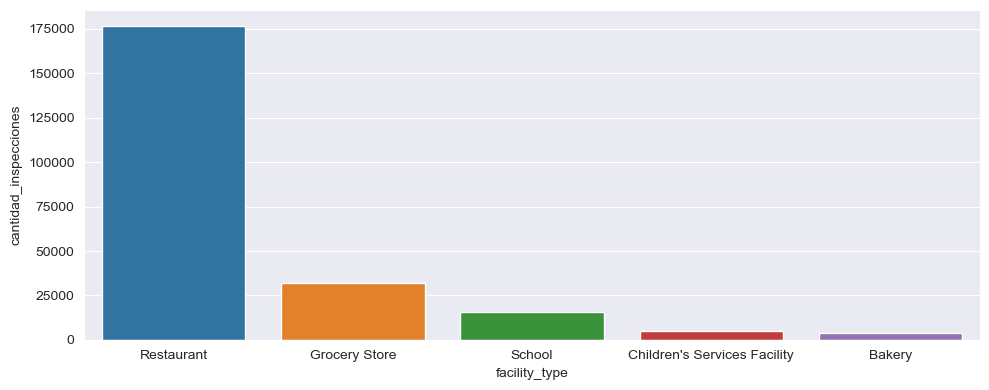

In [26]:
fig1 = plt.figure(figsize=(10,4))
sns.set_style('darkgrid')
sns.barplot(data=inspecciones_establecimientos, x = 'facility_type', y = 'cantidad_inspecciones')
#fig1.xticks(rotation=75)
fig1.tight_layout()
plt.show()

The 5 types of establishments with the most inspections are: 'Restaurant', 'Grocery Store', 'School', 'Restaurant\ndtype: object' and "Children's Services Facility".

In [37]:
import base64
from io import BytesIO

In [31]:
tmpfile = BytesIO()
fig1.savefig(tmpfile, format='png')
encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

html = '5 tipos de establecimientos con más inspecciones' + \
    '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

with open('fig1.html','w') as f:
    f.write(html)

## 3. How many inspections do you have in each year in the dataset?

Generate a bar chart

In [32]:
df['anio'] = pd.DatetimeIndex(df['inspection_date']).year

In [33]:
inspecciones_c_anio = pd.DataFrame(df.groupby('anio')['inspection_id'].count())

In [34]:
inspecciones_c_anio.reset_index(inplace=True)

In [35]:
inspecciones_c_anio.rename(columns={'inspection_id': 'cantidad_inspecciones'}, inplace=True)

<Axes: xlabel='anio', ylabel='cantidad_inspecciones'>

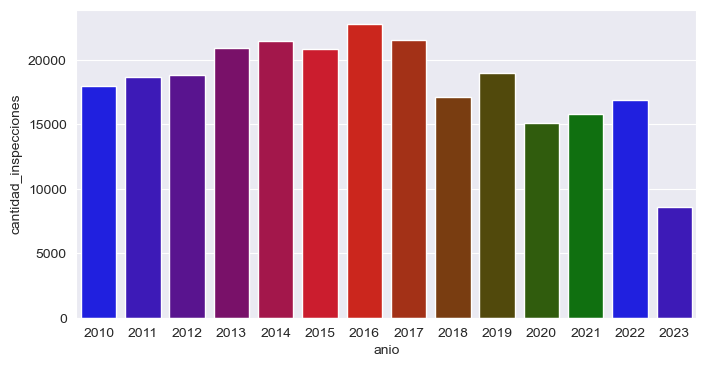

In [36]:
fig2 = plt.figure(figsize=(8,4))
sns.barplot(data = inspecciones_c_anio, x = 'anio', y = 'cantidad_inspecciones',
            palette=sns.blend_palette(['blue', 'red', 'green'], 12))

In [38]:
tmpfile = BytesIO()
fig2.savefig(tmpfile, format='png')
encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

html = 'Cantidad de inspecciones por cada año' + \
    '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

with open('fig2.html','w') as f:
    f.write(html)

## 4. What are the 5 most frequently performed inspections?

Generate a bar chart 

In [39]:
inspecciones_5 = pd.DataFrame(df['inspection_type'].value_counts().sort_values(ascending=False).head(5))

In [40]:
inspecciones_5.reset_index(inplace = True)

In [41]:
inspecciones_5.rename(columns={'index' : 'Inspection_type', 'inspection_type': 'cantidad_inspecciones'}, inplace=True)

In [42]:
inspecciones_5

,Inspection_type,cantidad_inspecciones
0,Canvass,133159
1,License,34098
2,Canvass Re-Inspection,27821
3,Complaint,24175
4,License Re-Inspection,11067


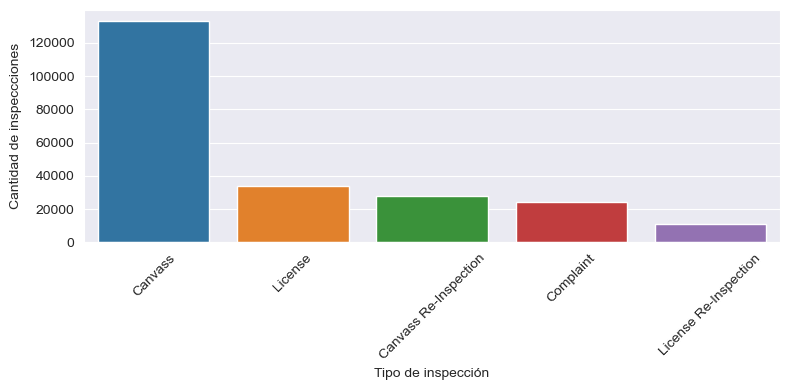

In [45]:
fig3 = plt.figure(figsize=(8,4))
sns.barplot(data = inspecciones_5, x = 'Inspection_type', y = 'cantidad_inspecciones')
plt.xticks(rotation=45)
plt.ylabel('Cantidad de inspeccciones')
plt.xlabel('Tipo de inspección')
fig3.tight_layout()
plt.show()

The 5 types of inspections most commonly performed on establishments are of: 'Canvass', 'License', 'Canvass Re-Inspection', 'Complaint' and 'License Re-Inspection'

In [46]:
tmpfile = BytesIO()
fig3.savefig(tmpfile, format='png')
encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

html = '5 inspecciones que más se realizan' + \
    '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

with open('fig3.html','w') as f:
    f.write(html)

## 5. Of the top 5 types of inspections in the dataset, what percentage does each of these types of inspections represent?

Generate a bar chart

In [47]:
inspecciones_5['porcentajes'] = inspecciones_5['cantidad_inspecciones']*100/df.shape[0]

In [48]:
inspecciones_5

,Inspection_type,cantidad_inspecciones,porcentajes
0,Canvass,133159,52.137840
1,License,34098,13.350927
2,Canvass Re-Inspection,27821,10.893194
3,Complaint,24175,9.465618
4,License Re-Inspection,11067,4.333237


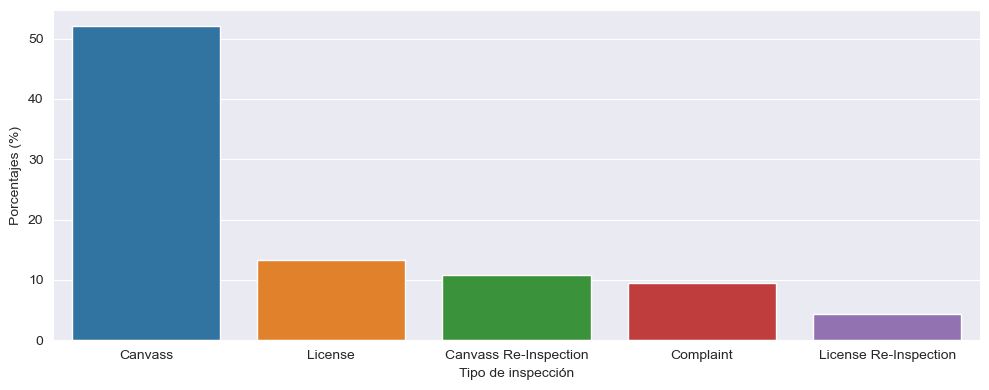

In [49]:
fig4 = plt.figure(figsize=(10,4))
sns.barplot(data=inspecciones_5, x = 'Inspection_type', y = 'porcentajes')
plt.ylabel('Porcentajes (%)')
plt.xlabel('Tipo de inspección')
fig4.tight_layout()
plt.show()

In [50]:
tmpfile = BytesIO()
fig4.savefig(tmpfile, format='png')
encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

html = 'Porcentaje top 5 de inspecciones' + \
    '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

with open('fig4.html','w') as f:
    f.write(html)

In [51]:
inspecciones_5['porcentajes'].sum()

90.1808158247128

## 6. What percentage of establishments have each type of outcome?

Generate a bar chart

In [52]:
df['results'].value_counts()

Pass                    131515
Fail                     49696
Pass w/ Conditions       39260
Out of Business          21736
No Entry                  9967
Not Ready                 3145
Business Not Located        79
Name: results, dtype: int64

In [53]:
df[['facility_type', 'results']].groupby(['results']).count().sort_values(by='facility_type', ascending=False)

,facility_type
results,
Pass,131515
Fail,49696
Pass w/ Conditions,39260
Out of Business,21736
No Entry,9967
Not Ready,3145
Business Not Located,79


In [54]:
porcentaje_resultado = pd.DataFrame(df['results'].value_counts(normalize = True)*100)

In [55]:
porcentaje_resultado.reset_index(inplace=True)

In [56]:
porcentaje_resultado.rename(columns={'index':'Resultado', 'results': 'Porcentaje'}, inplace=True)

In [57]:
porcentaje_resultado

,Resultado,Porcentaje
0,Pass,51.494139
1,Fail,19.458257
2,Pass w/ Conditions,15.372086
3,Out of Business,8.510638
4,No Entry,3.902536
5,Not Ready,1.231411
6,Business Not Located,0.030932


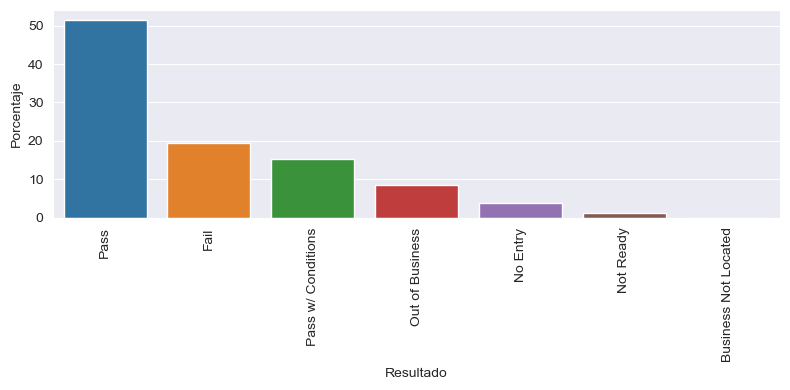

In [58]:
fig5 = plt.figure(figsize=(8,4))
sns.barplot(data=porcentaje_resultado, x='Resultado', y='Porcentaje')
plt.xticks(rotation=90)
fig5.tight_layout()
plt.show()

In [59]:
tmpfile = BytesIO()
fig5.savefig(tmpfile, format='png')
encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

html = 'Porcentaje establecimientos por tipo de resultado' + \
    '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

with open('fig5.html','w') as f:
    f.write(html)

In [60]:
porcentaje_resultado.Porcentaje.sum()

100.00000000000001

## 7. Generate a map with the places where inspections have been done, putting in one color the inspections that have passed and in another color the inspections that have not passed. Use the scatter_mapbox method from the plotly.express package.

Create a mapbox account in order to have a token and use it in the map.

In [61]:
import plotly.express as px

In [62]:
px.set_mapbox_access_token(open(".mapbox_token").read())

In [63]:
df.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'latitude', 'longitude', 'location',
       'violations', 'anio'],
      dtype='object')

In [ ]:

fig6 = plt.figure(figsize=(2,1))
fig6 = px.scatter_mapbox(data_frame=df, lat='latitude', lon='longitude', 
  opacity=0.5, 
  hover_name="results", 
  hover_data=["anio", 'risk'], 
  zoom=10)
fig6.update_layout(margin={"r":0,"t":0,"l":0,"b":0},  # remove the white gutter between the frame and map
        # hover appearance
        hoverlabel=dict( 
        bgcolor="white",     # white background
        font_size=16,        # label font size
        font_family="Inter") # label font
)

fig6.show()

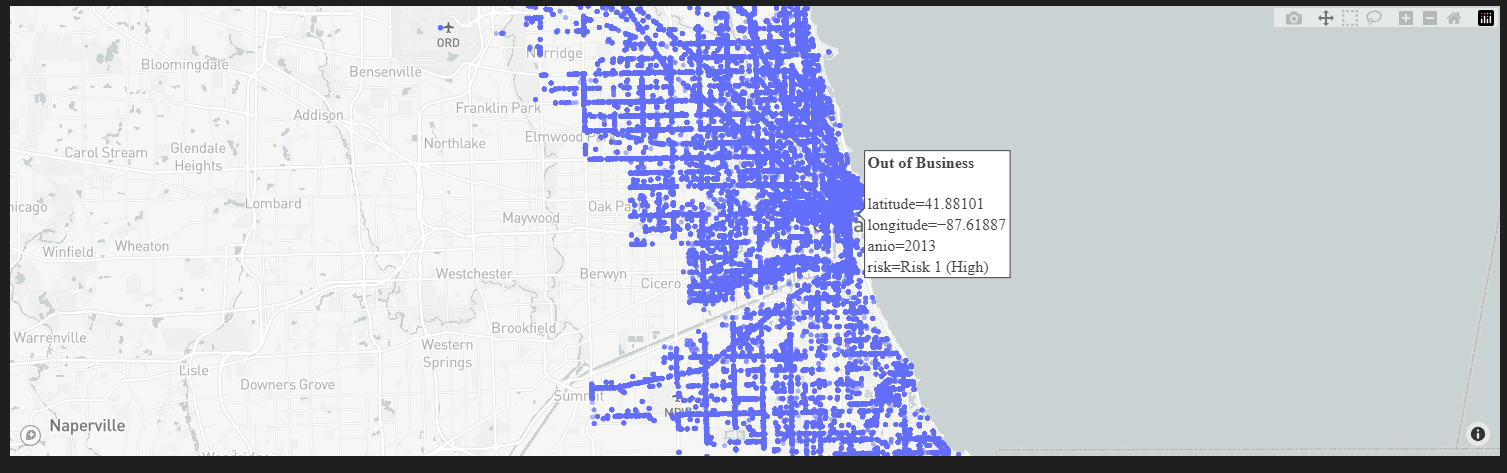

In [49]:
import chart_studio

In [50]:
username = 'dfvalenciag' 
api_key = 'xxxxxxxxxxxxxxxxxx' 
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

## Due to the large size of the figure, it was decided to use the go module of graph_objects to send the figure to an html

In [60]:
import plotly.graph_objects as go
mapbox_access_token = open(".mapbox_token").read()
fig7 = plt.figure(figsize=(3,2))
fig7 = go.Figure(go.Scattermapbox(
        lat=[df['latitude'][0]],
        lon=[df['longitude'][0]],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=5
        ),
        text=['Chicago'],
    ))

fig7.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=df['latitude'][0],
            lon=df['longitude'][0]
        ),
        pitch=0,
        zoom=9
    )
)

fig7.show()

<Figure size 300x200 with 0 Axes>

In [61]:
py.plot(fig7, filename = 'mapaChicagoFood', auto_open=True)

'https://plotly.com/~dfvalenciag/1/'

In [67]:
with open('figura_1.html', 'w') as f:
    f.write(html_fig)

In [71]:
figuras = [fig1, fig2, fig3, fig4, fig5]
html_figuras = [mpld3.fig_to_html(fig) for fig in figuras]

In [72]:
with open('figuras.html', 'w') as f:
    for html_figura in html_figuras:
        f.write(html_figura)